# Bitcoin Anomaly Analysis

In [1]:
import numpy as np
import pandas as pd

column_names = ['txn_key', 'from_user', 'to_user', 'date', 'amount']
df = pd.read_csv('../data/bitcoin_uic_data_and_code_20130410/user_edges.txt', names=column_names)

df.head()

,txn_key,from_user,to_user,date,amount
0,1,2,2,20130410142250,24.375000
1,1,2,782477,20130410142250,0.770900
2,2,620423,4571210,20111227114312,614.174951
3,2,620423,3,20111227114312,128.040520
4,3,3,782479,20130410142250,47.140520


In [2]:
df[ df.date < 20110000000000 ].to_csv('../data/subset/user_edges_2010.csv', index=False)

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('../data/subset/user_edges_2010.csv')

In [4]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

In [5]:
df.to_csv('../data/subset/user_edges_2010.csv', index=False)

Transaction Features to use
---------------------------

- Number of transaction under this key  
- Transaction amount, total amount under this key  
- From equals to?  
- Number of unique from/to under this key  
- Transaction date  
  - Year  
  - Month  
  - Day  
  - Day of week  
  - Day of year  
  - Hour  
  - Minute  
  - Second  


- From/to in/out (unique) degree  
- From/to clustering coefficient  
- From/to in/out transaction frequency  
  - All  
  - Within ±12 hours  
- From/to transaction volume  
  - All  
  - Within ±12 hours  
- From/to first transaction date  
- From/to average in/out transaction amount  
- From/to average time between in/out transactions  


In [6]:
import networkx as nx

# for features only defined in undirected graph
G = nx.from_pandas_dataframe(df, 
                             source='from_user', target='to_user', 
                             edge_attr=['txn_key', 'amount', 'date'], 
                             create_using=nx.Graph()
                            )

# unique links between users
G_di = nx.from_pandas_dataframe(df, 
                             source='from_user', target='to_user', 
                             edge_attr=['txn_key', 'amount', 'date'], 
                             create_using=nx.DiGraph()
                            )

# the full graph
G_mdi = nx.from_pandas_dataframe(df, 
                             source='from_user', target='to_user', 
                             edge_attr=['txn_key', 'amount', 'date'], 
                             create_using=nx.MultiDiGraph()
                            )

In [7]:
# transaction feature maps
count_by_key = df.groupby('txn_key').size()
amount_by_key = df.groupby('txn_key').amount.sum()
ufrom_by_key = df.groupby('txn_key').from_user.agg(pd.Series.nunique)
uto_by_key = df.groupby('txn_key').to_user.agg(pd.Series.nunique)

# user feature maps
in_txn_count = df.groupby('to_user').size()
in_key_count = df.groupby('to_user').txn_key.agg(pd.Series.nunique)

out_txn_count = df.groupby('from_user').size()
out_key_count = df.groupby('from_user').txn_key.agg(pd.Series.nunique)

total_in_txn_amt = df.groupby('to_user').amount.sum()
total_out_txn_amt = df.groupby('from_user').amount.sum()

avg_in_txn_amt = df.groupby('to_user').amount.mean()
avg_out_txn_amt = df.groupby('from_user').amount.mean()

from_fst_txn_date = df.groupby('from_user').date.min()


In [8]:
df_feat = df.assign(
    # transaction features
    count_by_key = df.txn_key.map(count_by_key), 
    amount_by_key = df.txn_key.map(amount_by_key), 
    from_eq_to = df.from_user == df.to_user, 
    ufrom_by_key = df.txn_key.map(ufrom_by_key), 
    uto_by_key = df.txn_key.map(uto_by_key), 
    
    # transaction date features
    date_year = df.date.dt.year, 
    date_month = df.date.dt.month, 
    date_day = df.date.dt.day, 
    date_dayofweek = df.date.dt.dayofweek, 
    date_dayofyear = df.date.dt.dayofyear, 
    date_hour = df.date.dt.hour, 
    date_minute = df.date.dt.minute, 
    date_second = df.date.dt.second, 
    
    # user features
    from_in_txn_count = df.from_user.map(in_txn_count), 
    from_in_key_count = df.from_user.map(in_key_count), 
    from_out_txn_count = df.from_user.map(out_txn_count), 
    from_out_key_count = df.from_user.map(out_key_count), 
    
    to_in_txn_count = df.to_user.map(in_txn_count), 
    to_in_key_count = df.to_user.map(in_key_count), 
    to_out_txn_count = df.to_user.map(out_txn_count), 
    to_out_key_count = df.to_user.map(out_key_count), 
    
    from_total_in_txn_amt = df.from_user.map(total_in_txn_amt), 
    from_total_out_txn_amt = df.from_user.map(total_out_txn_amt), 
    
    to_total_in_txn_amt = df.to_user.map(total_in_txn_amt), 
    to_total_out_txn_amt = df.to_user.map(total_out_txn_amt), 
    
    from_avg_in_txn_amt = df.from_user.map(avg_in_txn_amt), 
    from_avg_out_txn_amt = df.from_user.map(avg_out_txn_amt), 
    
    to_avg_in_txn_amt = df.to_user.map(avg_in_txn_amt), 
    to_avg_out_txn_amt = df.to_user.map(avg_out_txn_amt), 
    
    from_in_deg = df.from_user.map(G_mdi.in_degree()), 
    from_out_deg = df.from_user.map(G_mdi.out_degree()), 
    from_in_udeg = df.from_user.map(G_di.in_degree()), 
    from_out_udeg = df.from_user.map(G_di.out_degree()), 
    
    to_in_deg = df.to_user.map(G_mdi.in_degree()), 
    to_out_deg = df.to_user.map(G_mdi.out_degree()), 
    to_in_udeg = df.to_user.map(G_di.in_degree()), 
    to_out_udeg = df.to_user.map(G_di.out_degree()), 
    
    from_cc = df.from_user.map(nx.clustering(G)), 
    to_cc = df.to_user.map(nx.clustering(G))
    
)

df_feat.fillna(0, inplace=True)

In [9]:
from sklearn.ensemble import IsolationForest

not_train_cols = ['txn_key', 'from_user', 'to_user', 'date']
X_train = df_feat[ [col for col in df_feat.columns if col not in not_train_cols] ].values

clf = IsolationForest(n_estimators=100, 
                      contamination=0.01, 
                      n_jobs=-1, random_state=42)
clf.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=42,
        verbose=0)

In [17]:
pred = clf.predict(X_train[:2000])

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, #perplexity=50, 
            #n_iter=200, n_iter_without_progress=10, 
            #angle=0.7, 
            random_state=42)
X_tsne = tsne.fit_transform(X_train[:2000])

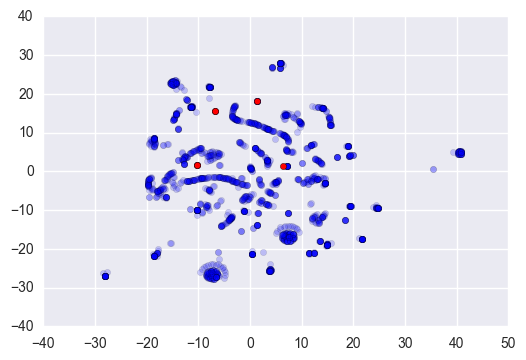

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

outlier = pred != 1

plt.scatter(X_tsne[~outlier][:,0], X_tsne[~outlier][:,1], c='b', alpha=.2)
plt.scatter(X_tsne[outlier][:,0], X_tsne[outlier][:,1], c='r', alpha=1)

In [1]:
from IPython.display import HTML
HTML('<script src="lib/d3/d3.min.js"></script>')